Intake-STAC + sat-search
================

Commonly, we'll use an API to search a large STAC catalog to narrow down the data we want to work with. Here we'll demonstrate using the [sat-search](https://github.com/sat-utils/sat-search) library that uses https://www.element84.com/earth-search/.

In [1]:
%matplotlib inline
import intake
import satsearch

In [2]:
bbox = [35.48, -3.24, 35.58, -3.14] # (min lon, min lat, max lon, max lat)
dates = '2020-07-01/2020-08-15'

URL='https://earth-search.aws.element84.com/v0'
results = satsearch.Search.search(url=URL,
                                  collections=['sentinel-s2-l2a-cogs'], # note collection='sentinel-s2-l2a-cogs' doesn't work
                                  datetime=dates,
                                  bbox=bbox,    
                                  sort=['<datetime'])

In [3]:
print('%s items' % results.found())
items = results.items()
# Save this locally for use later
items.save('my-s2-l2a-cogs.json')

18 items


In [4]:
type(items)

satstac.itemcollection.ItemCollection

In [5]:
catalog = intake.open_stac_item_collection(items)

In [6]:
list(catalog)

['S2A_36MYB_20200814_0_L2A',
 'S2A_36MYB_20200811_0_L2A',
 'S2B_36MYB_20200809_0_L2A',
 'S2B_36MYB_20200806_0_L2A',
 'S2A_36MYB_20200804_0_L2A',
 'S2A_36MYB_20200801_0_L2A',
 'S2B_36MYB_20200730_0_L2A',
 'S2B_36MYB_20200727_0_L2A',
 'S2A_36MYB_20200725_0_L2A',
 'S2A_36MYB_20200722_0_L2A',
 'S2B_36MYB_20200720_0_L2A',
 'S2B_36MYB_20200717_0_L2A',
 'S2A_36MYB_20200715_0_L2A',
 'S2A_36MYB_20200712_0_L2A',
 'S2B_36MYB_20200710_0_L2A',
 'S2B_36MYB_20200707_0_L2A',
 'S2A_36MYB_20200705_0_L2A',
 'S2A_36MYB_20200702_0_L2A']

In [7]:
item = catalog['S2A_36MYB_20200814_0_L2A']

In [8]:
# Assets for STAC Item
list(item)

['thumbnail',
 'overview',
 'info',
 'metadata',
 'visual',
 'B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B8A',
 'B09',
 'B11',
 'B12',
 'AOT',
 'WVP',
 'SCL']

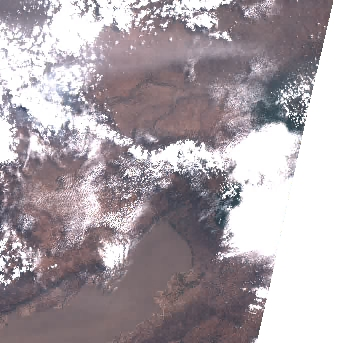

In [9]:
from IPython.display import Image
Image(item['thumbnail'].urlpath)

In [10]:
# full STAC JSON accessible as item._stac_obj._data
item.metadata

{'datetime': datetime.datetime(2020, 8, 14, 8, 11, tzinfo=tzlocal()),
 'platform': 'sentinel-2a',
 'constellation': 'sentinel-2',
 'instruments': ['msi'],
 'gsd': 10,
 'view:off_nadir': 0,
 'proj:epsg': 32736,
 'sentinel:latitude_band': 'M',
 'sentinel:grid_square': 'YB',
 'sentinel:sequence': '0',
 'sentinel:product_id': 'S2A_MSIL2A_20200814T074621_N0214_R135_T36MYB_20200814T103139',
 'sentinel:data_coverage': 85.74,
 'eo:cloud_cover': 47.78,
 'sentinel:valid_cloud_cover': True,
 'created': '2020-08-17T19:57:08.648Z',
 'updated': '2020-08-17T19:57:08.648Z',
 'sentinel:utm_zone': 36,
 'bbox': [34.79870551983084,
  -3.7056906919566326,
  35.755863403460744,
  -2.7110273448887328],
 'geometry': {'type': 'Polygon',
  'coordinates': [[[34.80044299251402, -3.7056906919566326],
    [34.79870551983084, -2.712838434794184],
    [35.755863403460744, -2.7110273448887328],
    [35.58561393371855, -3.4903485137854644],
    [35.53750206413227, -3.703878577458925],
    [34.80044299251402, -3.7056906

In [11]:
da = item.B04(chunks=dict(band=1, y=2048, x=2048)).to_dask()
da

<xarray.DataArray (band: 1, y: 10980, x: 10980)>
dask.array<open_rasterio-f343e00056f6e7c42e3b96f186e18e88<this-array>, shape=(1, 10980, 10980), dtype=uint16, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 9.7e+06 9.7e+06 9.7e+06 ... 9.59e+06 9.59e+06 9.59e+06
  * x        (x) float64 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05 8.098e+05
Attributes:
    transform:           (10.0, 0.0, 699960.0, 0.0, -10.0, 9700000.0)
    crs:                 +init=epsg:32736
    res:                 (10.0, 10.0)
    is_tiled:            1
    nodatavals:          (0.0,)
    scales:              (1.0,)
    offsets:             (0.0,)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE

In [12]:
# stack_bands() method should be identical to landsat
bands = ['nir','red']
stack = item.stack_bands(bands)
type(stack)

intake_stac.catalog.StacEntry

In [13]:
# Bug? currently need to specify chunks:
da = stack(chunks=dict(band=1, x=2048, y=2048)).to_dask()
da

<xarray.DataArray (band: 2, y: 10980, x: 10980)>
dask.array<concatenate, shape=(2, 10980, 10980), dtype=uint16, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) <U3 'B08' 'B04'
  * y        (y) float64 9.7e+06 9.7e+06 9.7e+06 ... 9.59e+06 9.59e+06 9.59e+06
  * x        (x) float64 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05 8.098e+05
Attributes:
    transform:           (10.0, 0.0, 699960.0, 0.0, -10.0, 9700000.0)
    crs:                 +init=epsg:32736
    res:                 (10.0, 10.0)
    is_tiled:            1
    nodatavals:          (0.0,)
    scales:              (1.0,)
    offsets:             (0.0,)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE

In [14]:
# Reorganize into xarray DataSet with common band names
da['band'] = bands
ds = da.to_dataset(dim='band')
ds

<xarray.Dataset>
Dimensions:  (x: 10980, y: 10980)
Coordinates:
  * y        (y) float64 9.7e+06 9.7e+06 9.7e+06 ... 9.59e+06 9.59e+06 9.59e+06
  * x        (x) float64 7e+05 7e+05 7e+05 ... 8.097e+05 8.097e+05 8.098e+05
Data variables:
    nir      (y, x) uint16 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
    red      (y, x) uint16 dask.array<chunksize=(2048, 2048), meta=np.ndarray>
Attributes:
    transform:           (10.0, 0.0, 699960.0, 0.0, -10.0, 9700000.0)
    crs:                 +init=epsg:32736
    res:                 (10.0, 10.0)
    is_tiled:            1
    nodatavals:          (0.0,)
    scales:              (1.0,)
    offsets:             (0.0,)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE

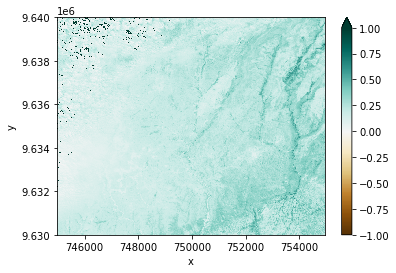

In [15]:
# Extract and plot NDVI subset
NDVI = (ds['nir'] - ds['red']) / (ds['nir'] + ds['red'])
#subset = NDVI.sel(y=slice(9.63e6,9.64e6), x=slice(7.55e5,7.71e5))
subset = NDVI.isel(y=slice(6000,7000), x=slice(4500,5500))
subset.plot.imshow(cmap='BrBG', vmin=-1, vmax=1)

In [16]:
! pip list 

Package                       Version                    Location
----------------------------- -------------------------- -----------------------------------------------
adal                          1.2.6
affine                        2.3.0
aiobotocore                   1.2.0
aiohttp                       3.7.3
aioitertools                  0.7.1
alembic                       1.5.4
antlr4-python3-runtime        4.7.2
appdirs                       1.4.4
argon2-cffi                   20.1.0
asciitree                     0.3.3
asn1crypto                    1.4.0
async-generator               1.10
async-timeout                 3.0.1
attrdict                      2.0.1
attrs                         20.3.0
awscli                        1.18.155
backcall                      0.2.0
backports.functools-lru-cache 1.6.1
beautifulsoup4                4.9.3
bleach                        3.3.0
blinker                       1.4
blosc                         1.10.2
bokeh                         2.2.

In [18]:
! cat 'my-s2-l2a-cogs.json' | python -m json.tool

{
    "id": "STAC",
    "description": "Single file STAC",
    "stac_version": "1.0.0-beta.2",
    "stac_extensions": [
        "single-file-stac"
    ],
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "stac_version": "1.0.0-beta.2",
            "stac_extensions": [
                "eo",
                "view",
                "proj"
            ],
            "id": "S2A_36MYB_20200814_0_L2A",
            "bbox": [
                34.79870551983084,
                -3.7056906919566326,
                35.755863403460744,
                -2.7110273448887328
            ],
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            34.80044299251402,
                            -3.7056906919566326
                        ],
                        [
                            34.79870551983084,
                            -

                    ],
                    "proj:transform": [
                        20,
                        0,
                        699960,
                        0,
                        -20,
                        9700000,
                        0,
                        0,
                        1
                    ]
                },
                "B08": {
                    "title": "Band 8 (nir)",
                    "type": "image/tiff; application=geotiff; profile=cloud-optimized",
                    "href": "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/M/YB/2020/8/S2A_36MYB_20200811_0_L2A/B08.tif",
                    "proj:shape": [
                        10980,
                        10980
                    ],
                    "proj:transform": [
                        10,
                        0,
                        699960,
                        0,
                        -10,
                        970000

                    ]
                },
                "B05": {
                    "title": "Band 5",
                    "type": "image/tiff; application=geotiff; profile=cloud-optimized",
                    "roles": [
                        "data"
                    ],
                    "gsd": 20,
                    "eo:bands": [
                        {
                            "name": "B05",
                            "center_wavelength": 0.7039,
                            "full_width_half_max": 0.019
                        }
                    ]
                },
                "B06": {
                    "title": "Band 6",
                    "type": "image/tiff; application=geotiff; profile=cloud-optimized",
                    "roles": [
                        "data"
                    ],
                    "gsd": 20,
                    "eo:bands": [
                        {
                            "name": "B06",
                            "center_

In [20]:
item['B04'].urlpath

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/M/YB/2020/8/S2A_36MYB_20200814_0_L2A/B04.tif'

In [24]:
!rio info https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/M/YB/2020/8/S2A_36MYB_20200814_0_L2A/B04.tif

{"blockxsize": 1024, "blockysize": 1024, "bounds": [699960.0, 9590200.0, 809760.0, 9700000.0], "colorinterp": ["gray"], "compress": "deflate", "count": 1, "crs": "EPSG:32736", "descriptions": [null], "driver": "GTiff", "dtype": "uint16", "height": 10980, "indexes": [1], "interleave": "band", "lnglat": [35.29332090760878, -3.208274342003706], "mask_flags": [["nodata"]], "nodata": 0.0, "res": [10.0, 10.0], "shape": [10980, 10980], "tiled": true, "transform": [10.0, 0.0, 699960.0, 0.0, -10.0, 9700000.0, 0.0, 0.0, 1.0], "units": [null], "width": 10980}


In [25]:
!rio info https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/M/YB/2020/8/S2A_36MYB_20200814_0_L2A/B04.tif | python -m json.tool

{
    "blockxsize": 1024,
    "blockysize": 1024,
    "bounds": [
        699960.0,
        9590200.0,
        809760.0,
        9700000.0
    ],
    "colorinterp": [
        "gray"
    ],
    "compress": "deflate",
    "count": 1,
    "crs": "EPSG:32736",
    "descriptions": [
        null
    ],
    "driver": "GTiff",
    "dtype": "uint16",
    "height": 10980,
    "indexes": [
        1
    ],
    "interleave": "band",
    "lnglat": [
        35.29332090760878,
        -3.208274342003706
    ],
    "mask_flags": [
        [
            "nodata"
        ]
    ],
    "nodata": 0.0,
    "res": [
        10.0,
        10.0
    ],
    "shape": [
        10980,
        10980
    ],
    "tiled": true,
    "transform": [
        10.0,
        0.0,
        699960.0,
        0.0,
        -10.0,
        9700000.0,
        0.0,
        0.0,
        1.0
    ],
    "units": [
        null
    ],
    "width": 10980
}


In [27]:
!gdalinfo '/vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/M/YB/2020/8/S2A_36MYB_20200814_0_L2A/B04.tif'

Driver: GTiff/GeoTIFF
Files: /vsicurl/https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/M/YB/2020/8/S2A_36MYB_20200814_0_L2A/B04.tif
Size is 10980, 10980
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 36S",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 36S",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",33,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
      